In [1]:
# Import functions from py scripts
from basic_functions import *
from bathymetry_functions import *

# Import librerias from python
import seaborn as sns
import matplotlib as mpl
import datetime
import glob
import os
import matplotlib.dates as mdates
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
import matplotlib.pylab as pl
from scipy import signal
from pytz import timezone
import pytz
import missingno as msno
from netCDF4 import Dataset, num2date
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import calendar

# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

import warnings
warnings.filterwarnings('ignore')

In [40]:
def angulo_norte(x,y):
    if x > 0 and y > 0:
        theta = 90 - (np.arctan((y/x))*(180/np.pi))
    elif x < 0 and y > 0:
        theta = 270 - (np.arctan((y/x))*(180/np.pi)) # artn (-)
    elif x < 0 and y < 0:
        theta = 270 - (np.arctan((y/x))*(180/np.pi))
    else:
        theta = 90 - (np.arctan((y/x))*(180/np.pi)) # artan(-)
    return theta

def min_ind_reshape (value1, vector1, value2, vector2, delta, view_coords:bool = None):
    """Función para encontrar la mínima diferencia entre dos celdas, usando una malla de cordenadas 
    ---------------------------------------------------------------------
    Input: 
    - Value1: valor a encontrar de la coordenada x
    - Vector1: vectores donde quiere encontrar dicho valor en la malla X 
    - Value2: valor a encontrar de la coordenada y
    - Vector2: vectores donde quiere encontrar dicho valor en la malla Y 
    - delta: radio para encontrar ese valor 
    - view_coords: Boleano para imprimr las cordenadas reales y en la malla
    ----------------------------------------------------------------------
    Output: 
    - Indi: Indice correpondiente a la fila 
    - Indj: Indice correspondiente a la columna
    """
    indices = np.where(((vector1 > value1-(delta)) & (vector1 < value1+(delta))) & 
                        ((vector2 > value2-(delta)) & (vector2 < value2+(delta))))[0]

    for i in range(len(indices)): 
        try :
            if( np.abs(vector1[indices[i]] - value1) < np.abs(vector1[indices[i+1]] - value1)) & (np.abs(vector2[indices[i]] - value2) < np.abs(vector2[indices[i+1]] - value2)):
                indi = indices[i]
            else:
                indi = indices[i+1]
        except:
            print('************error**********************')
    if view_coords == True:
        print(f'Indices: {indi}')
        print(f'Valor 1: {vector1[indi]}, Valor real 1: {value1}' )
        print(f'Valor 2: {vector2[indi]}, Valor real 2: {value2}' )
    return indi


def min_ind_reshape (value1, vector1, value2, vector2, delta, view_coords:bool = None):
    """Función para encontrar la mínima diferencia entre dos celdas, usando una malla de cordenadas 
    ---------------------------------------------------------------------
    Input: 
    - Value1: valor a encontrar de la coordenada x
    - Vector1: vectores donde quiere encontrar dicho valor en la malla X 
    - Value2: valor a encontrar de la coordenada y
    - Vector2: vectores donde quiere encontrar dicho valor en la malla Y 
    - delta: radio para encontrar ese valor 
    - view_coords: Boleano para imprimr las cordenadas reales y en la malla
    ----------------------------------------------------------------------
    Output: 
    - Indi: Indice correpondiente a la fila 
    - Indj: Indice correspondiente a la columna
    """
    indices = np.where(((vector1 > value1-(delta)) & (vector1 < value1+(delta))) & 
                        ((vector2 > value2-(delta)) & (vector2 < value2+(delta))))[0]

    for i in range(len(indices)): 
        try :
            if( np.abs(vector1[indices[i]] - value1) < np.abs(vector1[indices[i+1]] - value1)) & (np.abs(vector2[indices[i]] - value2) < np.abs(vector2[indices[i+1]] - value2)):
                indi = indices[i]
            else:
                indi = indices[i+1]
        except:
            print('************error**********************')
    if view_coords == True:
        print(f'Indices: {indi}')
        print(f'Valor 1: {vector1[indi]}, Valor real 1: {value1}' )
        print(f'Valor 2: {vector2[indi]}, Valor real 2: {value2}' )
    return indi


def plot_cells_data_base (variable:str ,lon:np.array, lat:np.array, plot_dfbat:bool, df_bat: pd.DataFrame = None):
    """
    Esta función plotea los centros de las celdas donde hay información de la base de datos
    -----------------------------------------------------------------------------------------
    Input:
    ------
    - variable: Nombre de la variable que se esta analizando
    - lon: arreglo de las longitudes de los datos obtenidos de la base de datos
    - lat:  arreglo de las latitudes de los datos obtenidos de la base de datos
    - plot_df_bat: True/ False: para plotear o no la ubicación de la malla con respecto a la base de datos 
    ------------------------------------------------------------------------------------------------------
    Output: 
    -------
    - Figure
    """ 

    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
    ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.stock_img()
    ax1.add_feature(cf.LAND, zorder= 10)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
    # ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


    colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
    i = 0
    for loni in (lon):
        for lati in (lat):
            ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
            i = i +1

    if plot_dfbat == True: 
        ax1.scatter(df_bat['lon'], df_bat['lat'],color = 'red', s=1)
    ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
    ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')

    # _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
    #           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
    fig.suptitle(f'Localización de los pixeles {variable}',size=12);
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.25)


def read_wind_era5(path):
    """Esta función lee los datos del archivo NETCdf de vientos
    -----------------------------------------------------------
    Input:
    ------
    - path: ruta del archivo
    - file_name: nombre del archivo
    """
    data = Dataset(f'{path}','r')
    lat = np.array(data.variables['latitude'][:])
    lon = np.array(data.variables['longitude'][:])
    nctime = np.array(data.variables['time'][:])
    t_unit = data.variables['time'].units
    t_cal = data.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    u10 = np.array(data.variables['u10'][:])
    v10 = np.array(data.variables['v10'][:])
    vel = np.sqrt(u10**2 + v10**2)
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    # col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
    
    direc_ = np.ones(shape=(u10.shape))
    for i in range(len(time)):
        for ilat in range(len(lat)):
            for ilon in range(len(lon)):
                direc_[i,ilat,ilon]= angulo_norte(u10[i,ilat,ilon],v10[i,ilat,ilon])

    dic_wind = {'time': time, 'lat': lat, 'lon':lon, 'u10': u10, 'v10':v10, 'Vel':vel, 'Direc':direc_}
    return dic_wind

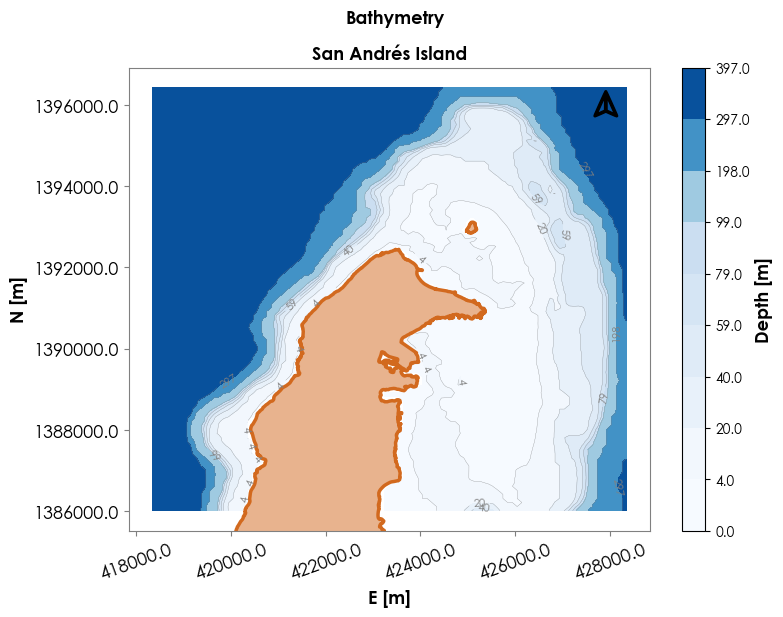

In [13]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line(path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

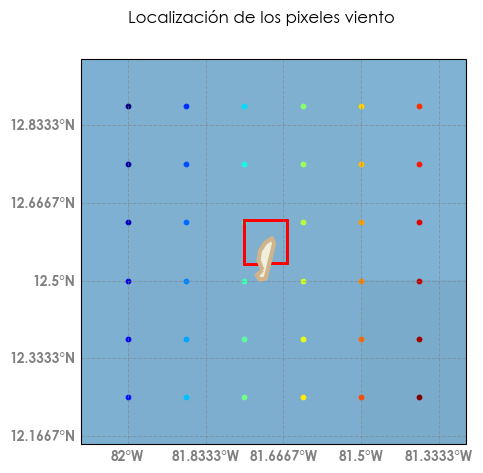

In [41]:
paths_wind = sorted(glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_ERA5\Data_Wind\*.nc"))
dic_wind = read_wind_era5(path = paths_wind[0])
plot_cells_data_base (variable = 'viento', lon = dic_wind['lon'] , lat = dic_wind['lat'], plot_dfbat = True, df_bat = df_bat_sai)

# Mean Values 

In [44]:
def mean_horly_pixel(lat:float, lon:float, paths:list):
    dic_data = {}
    for i, path in enumerate(paths):
        dic_pathi = read_wind_era5(path=path)
        lat_serie = dic_pathi['lat'] # Para iniciar de abajo hacia arriba
        lon_serie = dic_pathi['lon']
        ind_lat = np.where(lat_serie == lat )[0][0]
        ind_lon = np.where(lon_serie == lon )[0][0]
        df_pathi = pd.DataFrame({'time':dic_pathi['time'], 
                                'u10':dic_pathi['u10'][:,ind_lat, ind_lon], 'v10':dic_pathi['v10'][:,ind_lat, ind_lon], 
                                'Vel':dic_pathi['Vel'][:,ind_lat, ind_lon],'Direc':dic_pathi['Direc'][:,ind_lat, ind_lon]})
        dic_data.update({i:df_pathi})
    
    df_pixel = pd.concat(dic_data, ignore_index=True)


    df_grouped = df_pixel.groupby([df_pixel['time'].dt.month, df_pixel['time'].dt.day, df_pixel['time'].dt.hour]).mean()
    df_grouped.index.set_names(['month', 'day', 'hour'], level=[0,1,2], inplace=True)
    df_grouped = df_grouped.reset_index()

    df_grouped['year'] = list(map(lambda x: int(x), np.ones(len(df_grouped))*2000))
    # df_grouped['time'] = pd.to_datetime(df_grouped[['year','month', 'day','hour']], format=format).dt.strftime('%m-%d')
    df_grouped['time'] = pd.to_datetime(df_grouped[['year','month', 'day','hour']], format=format)
    df_grouped.set_index('time', inplace=True)
    df_grouped = df_grouped.iloc[:,:-1]

    return df_grouped


def func_dic_data_pixels (lat:np.array, lon:np.array, paths:list):
    dic_db = {}
    k = 0 
    for j in range(len(lat)):
        for i in range(len(lon)):
            df_pixel_i = mean_horly_pixel(lat = lat[j], lon= lon[i], paths= paths)
            dic_db.update({k:df_pixel_i})
            k = k+1
    return dic_db

def men_values_ (dic_pixels:dict, ind:int):
    """_summary_

    Parameters
    ----------
    dic_pixels : dict
        Diccionario que contiene los data frame de cada pixel 
    ind : int
        indice del pixel a analizar 
    variable : str
        variable a evaluar ('Hs', 'Tp', 'Direc')

    Returns
    -------
    _pd.dataframe_
        Dataframe de los valores medios, y los valores medios agrupados por mes
    """
    df_mean = dic_pixels[ind]
    df_mean['time'] = df_mean.index
    df_mean_grouby = dic_pixels[ind].groupby('month').mean()
    df_mean = df_mean.merge(df_mean_grouby, on='month').set_index('time')
    return df_mean

In [45]:
paths_wind = sorted(glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_ERA5\Data_Wind\*.nc"))
dic_wind = read_wind_era5(path = paths_wind[0])
lat = dic_wind['lat'] # Para iniciar de abajo hacia arriba
lon = dic_wind['lon']
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
lon_re = np.reshape(lon_mesh, len(lat)*len(lon))
lat_re = np.reshape(lat_mesh, len(lat)*len(lon))

# Diccionario de los pixeles 
dic_pixels = func_dic_data_pixels(lat = lat, lon= lon,  paths= paths_wind)

In [46]:
# Pixel al noreste
lat_sai_ne, lon_sai_ne = 12.63, 360-81.66
ind_ne = min_ind_reshape(value1 = lat_sai_ne, vector1 = lat_re, value2 = lon_sai_ne, vector2 = lon_re, delta = 0.125, view_coords = True)

#Pixel al noroeste
lat_sai_nw, lon_sai_nw = 12.63, 360-81.85
ind_nw = min_ind_reshape(value1 = lat_sai_nw, vector1 = lat_re, value2 = lon_sai_nw, vector2 = lon_re, delta = 0.125, view_coords = True)


# Pixel al sureste
lat_sai_se, lon_sai_se = 12.5, 360-81.66
ind_se = min_ind_reshape(value1 = lat_sai_se, vector1 = lat_re, value2 = lon_sai_se, vector2 = lon_re, delta = 0.125, view_coords = True)

#Pixel al suroeste
lat_sai_sw, lon_sai_sw = 12.5, 360-81.85
ind_sw = min_ind_reshape(value1 = lat_sai_sw, vector1 = lat_re, value2 = lon_sai_sw, vector2 = lon_re, delta = 0.125, view_coords = True)

************error**********************
Indices: 15
Valor 1: 12.625, Valor real 1: 12.63
Valor 2: 278.375, Valor real 2: 278.34000000000003
************error**********************
Indices: 14
Valor 1: 12.625, Valor real 1: 12.63
Valor 2: 278.25, Valor real 2: 278.15
************error**********************
Indices: 21
Valor 1: 12.5, Valor real 1: 12.5
Valor 2: 278.375, Valor real 2: 278.34000000000003
************error**********************
Indices: 20
Valor 1: 12.5, Valor real 1: 12.5
Valor 2: 278.25, Valor real 2: 278.15


In [53]:
# Hacer los promedios de los datos 
df_mean_ne = men_values_ (dic_pixels = dic_pixels, ind = ind_ne)
# df_mean_ne.reset_index(inplace=True)
df_mean_nw = men_values_ (dic_pixels = dic_pixels, ind = ind_nw)
# df_mean_nw.reset_index(inplace=True)

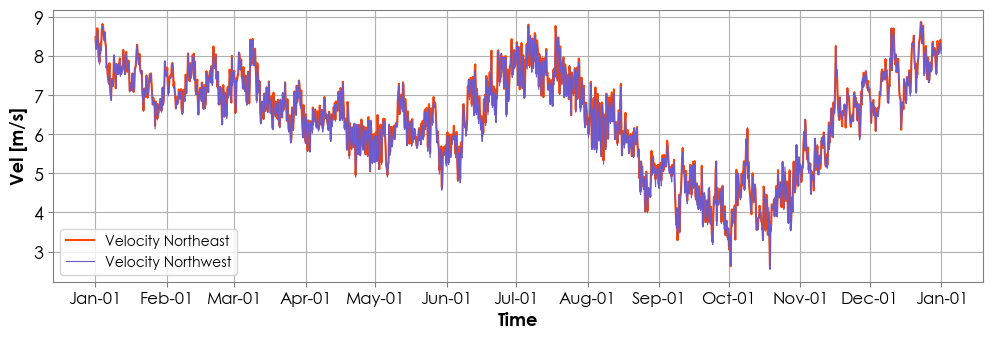

In [55]:
fig, ax = plt.subplots(figsize = (12,4))

ax_  = df_mean_ne[['Vel_x']].plot(ax = ax, x_compat = True, color = 'orangered', lw = 1.5)
ax_ = df_mean_nw[['Vel_x']].plot(ax = ax, x_compat = True, color = 'slateblue', lw = 0.8)
fig_params(ax)
ax_.set_ylabel('Vel [m/s]', size = 13, fontweight = 'bold')
ax_.set_xlabel('Time', size = 13, fontweight = 'bold')
ax.legend(['Velocity Northeast', 'Velocity Northwest'])
ax.set_xticklabels(ax.get_xticks(), rotation =0, ha="center", size = 12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

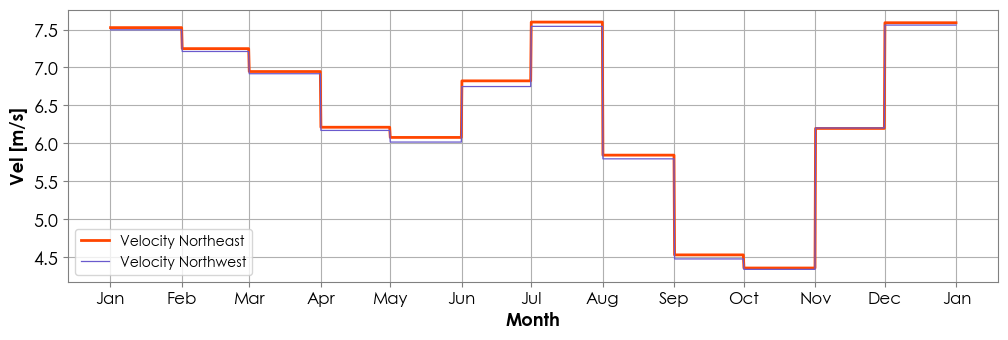

In [56]:
fig, ax = plt.subplots(figsize = (12,4))
months_names = calendar.month_abbr[1:]


# ax_  = df_mean_ne[['Hs_y']].plot(ax = ax,x_compat = True ,marker = 'o', ls = ' ', ms = 2)
# ax_ = df_mean_nw[['Hs_y']].plot(ax = ax,x_compat = True ,marker = 'o', ls = ' ', ms = 2)

ax_  = df_mean_ne[['Vel_y']].plot(ax = ax,x_compat = True, color = 'orangered', lw = 2)
ax_ = df_mean_nw[['Vel_y']].plot(ax = ax,x_compat = True, color = 'slateblue', lw = 0.9 )
fig_params(ax)
ax_.set_ylabel('Vel [m/s]', size = 13, fontweight = 'bold')
ax_.set_xlabel('Month', size = 13, fontweight = 'bold')
ax.legend(['Velocity Northeast', 'Velocity Northwest'])
ax.set_xticklabels(ax.get_xticks(), rotation =0, ha="center", size = 12)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=1))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Extreme Values

In [60]:
def df_data_series_pixel(lat:float, lon:float, paths:list):
    """Función para obetner la serie de tiempo por pixel 

    Parameters
    ----------
    lat : float
        Latitud del centro del pixel
    lon : float
        Longitud del centro del pixel
    paths : list
        Lista de las rutas de los archivos

    Returns
    -------
    df_pixel
        Dataframe de la serie de tiempo de los datos 
    """
    dic_data = {}
    for i, path in enumerate(paths):
        dic_pathi = read_wind_era5(path=path)
        lat_serie = dic_pathi['lat'] # Para iniciar de abajo hacia arriba
        lon_serie = dic_pathi['lon']
        ind_lat = np.where(lat_serie == lat )[0][0]
        ind_lon = np.where(lon_serie == lon )[0][0]
        df_pathi = pd.DataFrame({'time':dic_pathi['time'], 
                                'u10':dic_pathi['u10'][:,ind_lat, ind_lon], 'v10':dic_pathi['v10'][:,ind_lat, ind_lon], 
                                'Vel':dic_pathi['Vel'][:,ind_lat, ind_lon],'Direc':dic_pathi['Direc'][:,ind_lat, ind_lon]})
        dic_data.update({i:df_pathi})
    
    df_pixel = pd.concat(dic_data, ignore_index=True).set_index('time')
    lis_season = []
    for item, row in df_pixel.iterrows():
        if (item.month <= 4) & (item.month >= 1):
            lis_season.append(0)
        else:
            lis_season.append(1)

    df_pixel['Season'] = lis_season
    df_pixel ['month'] =  df_pixel.index.month
    return df_pixel

def fun_agregacion(df_pixel:pd.DataFrame, variable:str):
    """Función para generar las funciones de agregación del los datos de un pixel

    Parameters
    ----------
    df_pixel : pd.DataFrame
        Dataframe que contiene toda la serie de datos
    variable : str
        Variable a generar las funciones de agregación

    Returns
    -------
    _type_
        -df_grouped: datafarme con las funciones de agregación aplicadas a la variable especficada
        -df_season: data frame con las funciones de agregación aplicadas a las estaciones
    """

    df_pixel_var = df_pixel[variable].to_frame()

    def q_90(x):
        return x.quantile(0.90)

    def q_95(x):
        return x.quantile(0.95)

    
    def q_99(x):
        return x.quantile(0.99)

    def q_25(x):
        return x.quantile(0.25)
    
    def q_75(x):
        return x.quantile(0.75)


    f = {variable: ['mean',q_25, q_75, q_90, q_95, q_99]}
    df_grouped = df_pixel_var.groupby([df_pixel_var.index.month, df_pixel_var.index.day]).agg(f)
    df_grouped.index.set_names(['month', 'day'], level= [0,1], inplace=True)
    df_grouped = df_grouped.reset_index()
    df_grouped['year'] = list(map(lambda x: int(x), np.ones(len(df_grouped))*2000))
    # df_grouped['hour'] = list(map(lambda x: int(x), np.ones(len(df_grouped))*0))
    df_grouped['time'] = pd.to_datetime(pd.DataFrame({'year':df_grouped['year'], 'month':df_grouped['month'], 'day':df_grouped['day']}))
    # df_grouped.set_index('time', inplace=True)
    # df_grouped = df_grouped.iloc[:,:-1]

    df_month = df_pixel_var.groupby([df_pixel_var.index.month]).agg(f)
    df_month.index.set_names(['month'], inplace=True)
    df_month = df_month.reset_index()

    df_grouped = df_grouped.merge(df_month, on = 'month')
    df_grouped.set_index('time', inplace=True)
    
    df_season = df_pixel.groupby(['Season']).agg(f)[variable]
    df_season.index.set_names(['Season'],inplace=True)
    df_season = df_season.reset_index()

    return df_season, df_grouped

def fig_boxplot (figsize:tuple, df_pixel:pd.DataFrame, x_variable:str, variable:str, palette_color:str, alpha:float, width_box:float):
    """Función para obseter los boxplot por mes y estación del conjunto de datos

    Parameters
    ----------
    figsize : tuple
        Tamaño de la figura
    df_pixel : pd.DataFrame
        Data Frame del conjunto de datos
    x_variable : str
        variable clasificatoria ('Month', 'Season')
    variable : str
        Serie de datos a plotear ('u10', 'v10, 'Vel', 'Direc')
    palette_color : str
        Color de los diagram boxplot
    alpha : float
        apha de los colores del boxplot
    """

    fig, ax = plt.subplots(figsize = figsize)
    PROPS = {'boxprops':{'edgecolor':'k', 'alpha':alpha}, 
            'medianprops':{"color": "k", 'linewidth':2}, 
            'flierprops':{"marker": "x", 'markersize':6, 'markeredgecolor':'k'},            
            'whiskerprops':{'color':'k'},
            'capprops':{'color':'k'},
            'meanprops':{"marker":"o","markerfacecolor":"lavender", "markeredgecolor":"purple", 'markersize':5}}
    sns.boxplot(data= df_pixel, x= x_variable,  y= variable, ax = ax, width= width_box, palette= palette_color, showmeans=True,**PROPS)
    if x_variable == 'month':
        names_month = calendar.month_abbr[1:]
        ax.set_xticklabels(names_month)
        ax.set_xlabel('Month', size = 13, fontweight = 'bold')
    elif x_variable == 'Season':
        names_seasons = ['Dry', 'Wet']
        ax.set_xticklabels(names_seasons)
        ax.set_xlabel('Season', size = 13, fontweight = 'bold')        

    if (variable == 'u10') | (variable == 'v10'):
        ax.set_ylabel(f'{variable} [m/s]', size = 13, fontweight = 'bold')
    elif variable == 'Vel':
        ax.set_ylabel('Vel [m/s]', size = 13, fontweight = 'bold')
    elif variable == 'Direc':
        ax.set_ylabel('Dir [deg]', size = 13, fontweight = 'bold')           
    ax.set_axisbelow(True)
    fig_params(ax)
    ax.grid(False)
    ax.grid(axis= 'y',linestyle= 'dashed')

def stationaly_figure(variable:str, data1:pd.Series, data2_fill:pd.Series, data3_fill:pd.Series, label_fill:str, 
                        color_plot:str, label_plot:str, lw_plot:float, bottom_legend:float, compare_plot:bool, data_compare1:pd.Series = None, 
                        data_compare_fill2:pd.Series = None, data_compare_fill3:pd.Series = None, color_fill_compare:str = None, 
                        label_fill_compare:str = None, color_plot_compare:str = None, label_plot_compare:str = None, lw_plot_compare:float = None ):
    """Esta función grafica la serie con fill between entre dos series inferiores y superiores

    Parameters
    ----------
    variable : str
        Nombre de la variable a pintar ('u10', 'v10, 'Vel', 'Direc')
    data1 : pd.Series
        Serie que sera graficada como una linea 1D
    data2_fill : pd.Series
        Serie inferior para graficar el fill between
    data3_fill : pd.Series
        Serie superior para graficar el fill between
    color_fill : str
        Color del fill between
    label_fill : str
        label del fill between
    color_plot : str
        Color del plot
    label_plot : str
        label del plot
    bottom_legend : float
        Ubicacion de la leyenda en la parte inferior
    width : float
        Ancho del box
    """
    fig, ax = plt.subplots(figsize = (10,3))
    ax.fill_between(data1.index,data2_fill,data3_fill,facecolor = color_plot, label = label_fill, alpha = 0.2)
    ax.plot(data1, color = color_plot, label =label_plot, lw = lw_plot)
    if compare_plot == True:
        ax.fill_between(data_compare1.index,data_compare_fill2,data_compare_fill3, facecolor = color_plot_compare,alpha = 0.2, label = label_fill_compare)
        ax.plot(data_compare1, color = color_plot_compare, label =label_plot_compare, lw = lw_plot_compare)
    fig_params(ax)
    ax.set_xlabel('Time', size = 13, fontweight = 'bold')
    if (variable == 'u10') | (variable == 'v10'):
        ax.set_ylabel(f'{variable} [m/s]', size = 13, fontweight = 'bold')
    elif variable == 'Vel':
        ax.set_ylabel('Vel [m/s]', size = 13, fontweight = 'bold')
    elif variable == 'Direc':
        ax.set_ylabel('Dir [deg]', size = 13, fontweight = 'bold')    
    ax.set_xticklabels(ax.get_xticks(), rotation =0, ha="center", size = 12)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
            fancybox=True, shadow=True, ncol=2, fontsize = 10)
    # ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

In [61]:
df_data = df_data_series_pixel(lat = lat_re[ind_ne], lon = lon_re[ind_ne], paths = paths_wind)
df_season, df_grouped = fun_agregacion(df_pixel = df_data, variable='Vel')
df_season_dir, df_grouped_dir = fun_agregacion(df_pixel = df_data, variable='Direc')


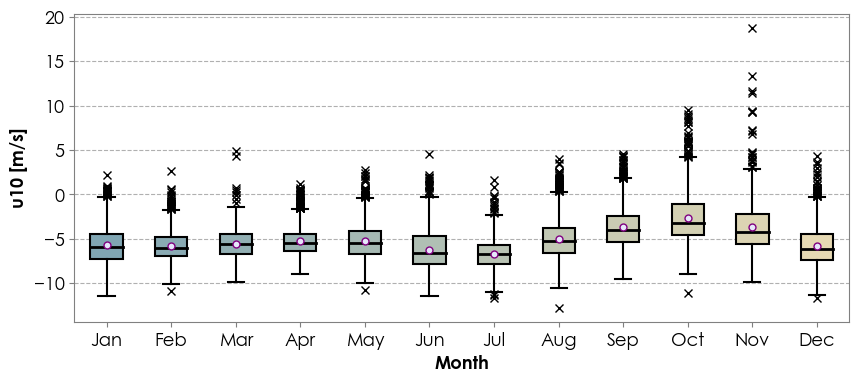

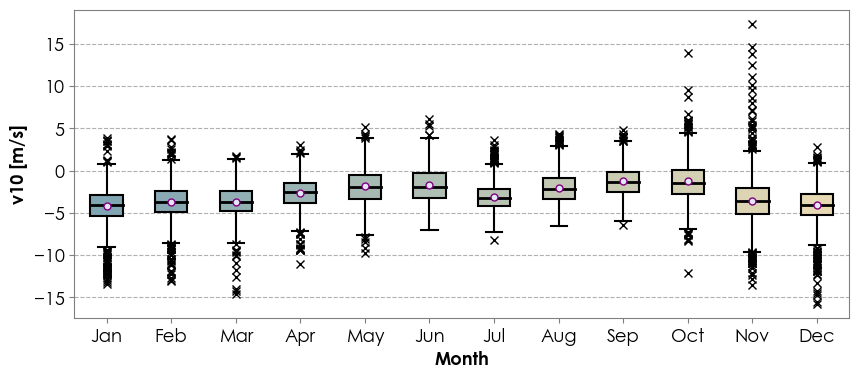

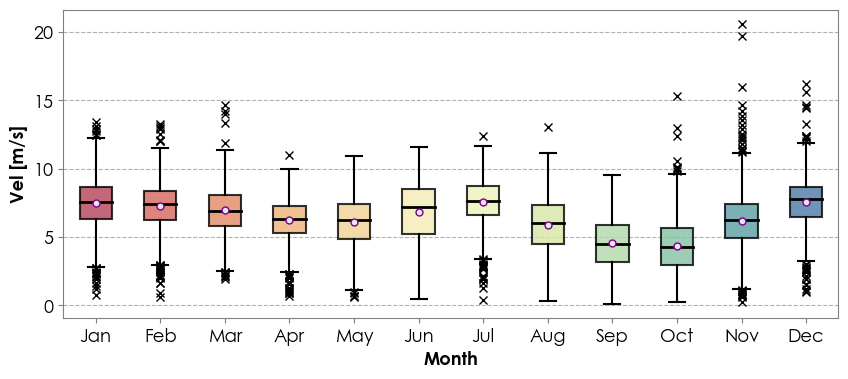

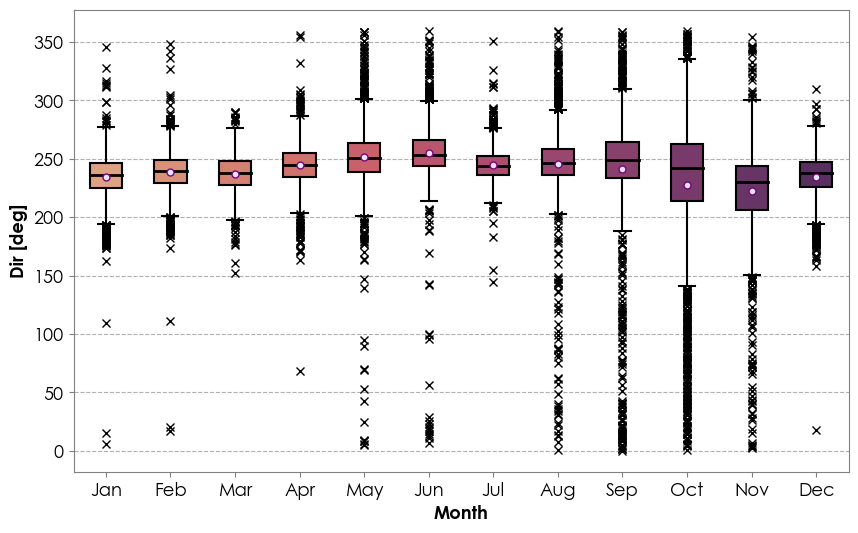

In [62]:
fig_boxplot(figsize = (10,4) , df_pixel = df_data, x_variable='month', variable='u10', palette_color="blend:#7AB,#EDA", alpha = 1, width_box = 0.5)
fig_boxplot(figsize = (10,4) , df_pixel = df_data, x_variable='month', variable='v10', palette_color="blend:#7AB,#EDA", alpha = 1, width_box = 0.5)
fig_boxplot(figsize = (10,4) , df_pixel = df_data, x_variable='month', variable='Vel', palette_color="Spectral", alpha = 0.8, width_box = 0.5)
fig_boxplot(figsize = (10,6) , df_pixel = df_data, x_variable='month', variable='Direc', palette_color='flare', alpha = 1, width_box = 0.5)


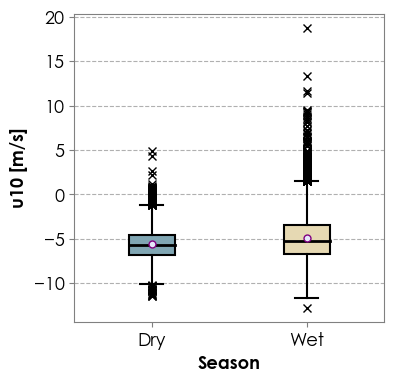

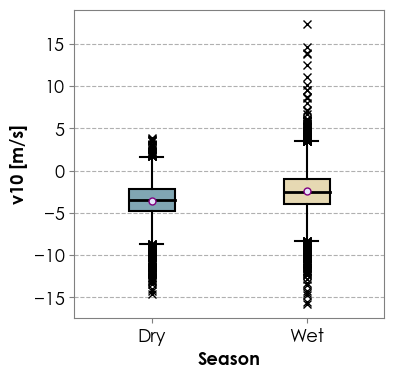

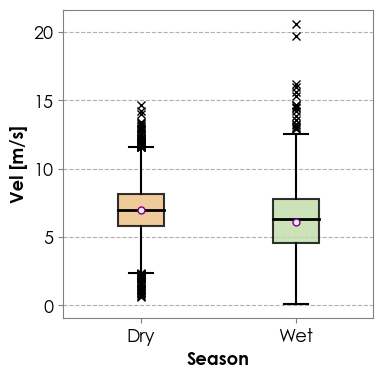

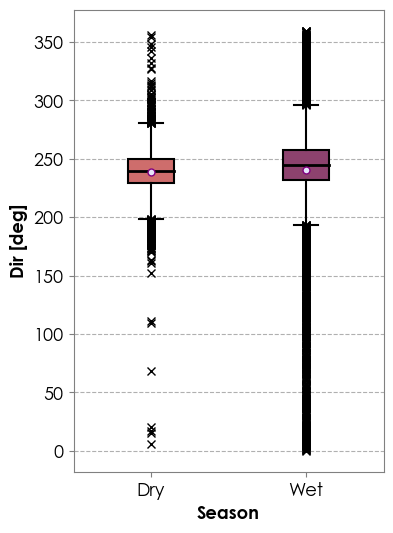

In [63]:
fig_boxplot(figsize =(4,4) , df_pixel = df_data, x_variable='Season', variable='u10', palette_color='blend:#7AB,#EDA', alpha = 1, width_box = 0.3)
fig_boxplot(figsize =(4,4) , df_pixel = df_data, x_variable='Season', variable='v10', palette_color='blend:#7AB,#EDA', alpha = 1, width_box = 0.3)
fig_boxplot(figsize =(4,4) , df_pixel = df_data, x_variable='Season', variable='Vel', palette_color="Spectral", alpha = 0.8,width_box = 0.3)
fig_boxplot(figsize =(4,6) , df_pixel = df_data, x_variable='Season', variable='Direc', palette_color='flare', alpha = 1, width_box = 0.3)


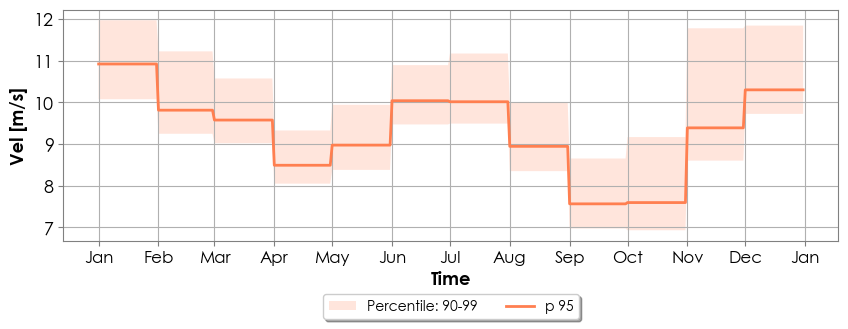

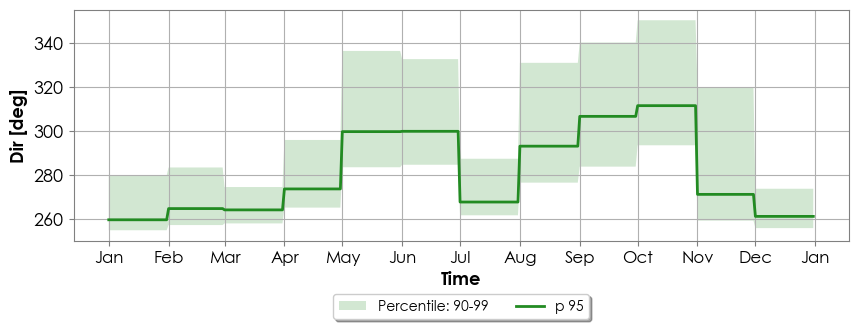

In [66]:
stationaly_figure(variable = 'Vel', data1=df_grouped['Vel_y']['q_95'], data2_fill= df_grouped['Vel_y']['q_90'], 
            data3_fill= df_grouped['Vel_y']['q_99'], label_fill = 'Percentile: 90-99', 
            color_plot = 'coral',label_plot = 'p 95', lw_plot = 2, bottom_legend = -0.2, compare_plot = False)

stationaly_figure(variable = 'Direc', data1=df_grouped_dir['Direc_y']['q_95'], data2_fill= df_grouped_dir['Direc_y']['q_90'], 
            data3_fill= df_grouped_dir['Direc_y']['q_99'],label_fill = 'Percentile: 90-99', 
            color_plot = 'forestgreen',label_plot = 'p 95', lw_plot = 2, bottom_legend = -0.2, compare_plot = False)

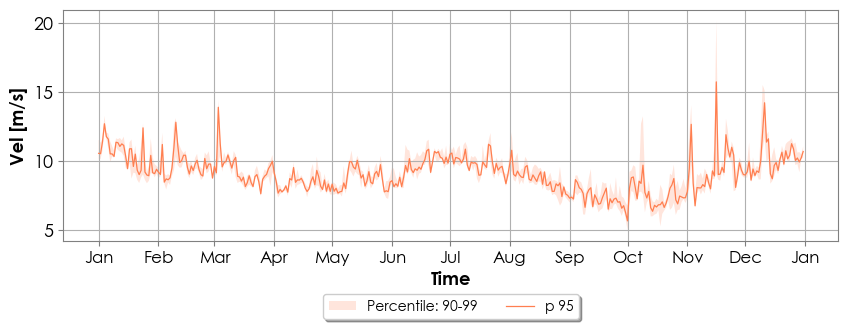

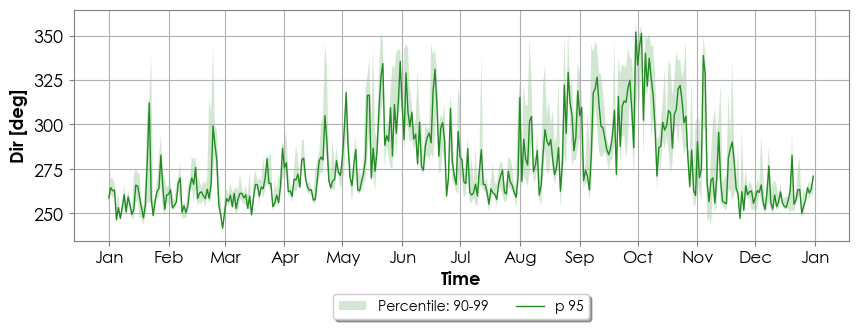

In [67]:
stationaly_figure(variable = 'Vel',data1=df_grouped['Vel_x']['q_95'], data2_fill= df_grouped['Vel_x']['q_90'], 
            data3_fill= df_grouped['Vel_x']['q_99'], label_fill = 'Percentile: 90-99', 
            color_plot = 'coral',label_plot = 'p 95', lw_plot= 0.9, bottom_legend = -0.2, compare_plot = False)

stationaly_figure(variable = 'Direc', data1=df_grouped_dir['Direc_x']['q_95'], data2_fill= df_grouped_dir['Direc_x']['q_90'], 
            data3_fill= df_grouped_dir['Direc_x']['q_99'],label_fill = 'Percentile: 90-99',
            color_plot = 'forestgreen',label_plot = 'p 95', lw_plot = 1, bottom_legend = -0.2, compare_plot = False)

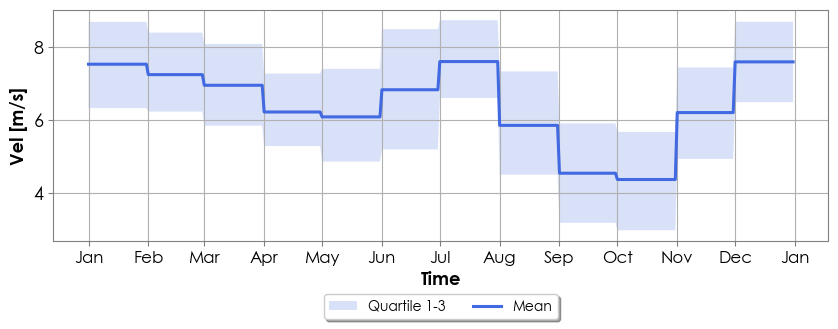

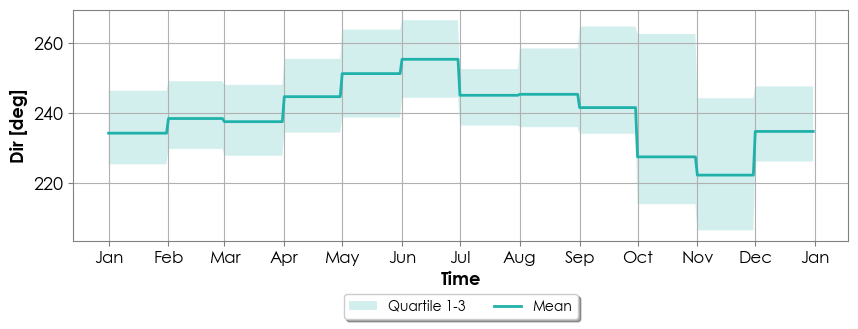

In [68]:
stationaly_figure(variable = 'Vel', data1=df_grouped['Vel_y']['mean'], data2_fill= df_grouped['Vel_y']['q_25'], 
            data3_fill= df_grouped['Vel_y']['q_75'],label_fill = 'Quartile 1-3', 
            color_plot = 'royalblue',label_plot = 'Mean', lw_plot= 2.2, bottom_legend = -0.2, compare_plot = False)

stationaly_figure(variable = 'Direc', data1=df_grouped_dir['Direc_y']['mean'], data2_fill= df_grouped_dir['Direc_y']['q_25'], 
            data3_fill= df_grouped_dir['Direc_y']['q_75'],label_fill = 'Quartile 1-3', 
            color_plot = 'lightseagreen',label_plot = 'Mean', lw_plot = 2, bottom_legend = -0.2, compare_plot = False)

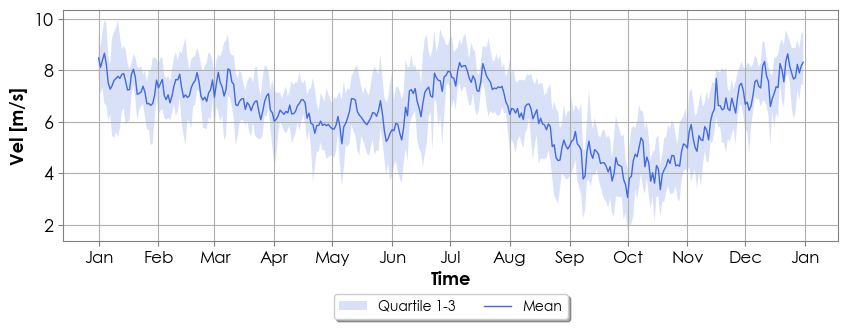

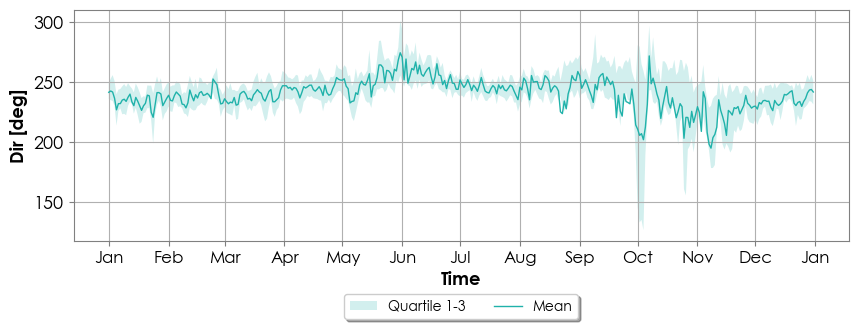

In [69]:
stationaly_figure(variable = 'Vel', data1=df_grouped['Vel_x']['mean'], data2_fill= df_grouped['Vel_x']['q_25'], 
            data3_fill= df_grouped['Vel_x']['q_75'],label_fill = 'Quartile 1-3', 
            color_plot = 'royalblue',label_plot = 'Mean', lw_plot= 1, bottom_legend = -0.2, compare_plot = False)

stationaly_figure(variable = 'Direc', data1=df_grouped_dir['Direc_x']['mean'], data2_fill= df_grouped_dir['Direc_x']['q_25'], 
            data3_fill= df_grouped_dir['Direc_x']['q_75'],label_fill = 'Quartile 1-3', 
            color_plot = 'lightseagreen',label_plot = 'Mean', lw_plot = 1, bottom_legend = -0.2, compare_plot = False)

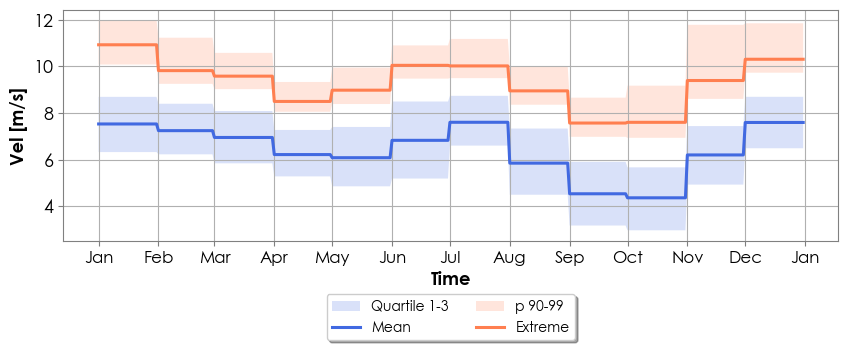

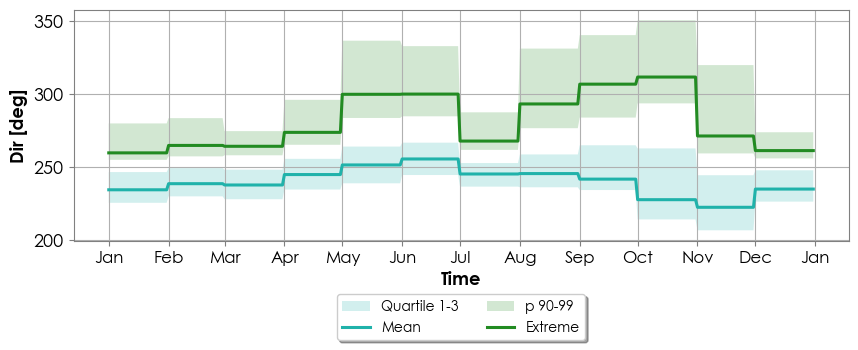

In [70]:
stationaly_figure(variable = 'Vel',data1=df_grouped['Vel_y']['mean'], data2_fill= df_grouped['Vel_y']['q_25'], 
            data3_fill= df_grouped['Vel_y']['q_75'] ,label_fill = 'Quartile 1-3', 
            color_plot = 'royalblue',label_plot = 'Mean', lw_plot= 2.2, bottom_legend = -0.2, compare_plot = True,data_compare1= df_grouped['Vel_y']['q_95'], 
                        data_compare_fill2=df_grouped['Vel_y']['q_90'], data_compare_fill3 = df_grouped['Vel_y']['q_99'], 
                        label_fill_compare = 'p 90-99', color_plot_compare = 'coral', label_plot_compare= 'Extreme', lw_plot_compare= 2.2)


stationaly_figure(variable = 'Direc',data1=df_grouped_dir['Direc_y']['mean'], data2_fill= df_grouped_dir['Direc_y']['q_25'], 
            data3_fill= df_grouped_dir['Direc_y']['q_75'] ,label_fill = 'Quartile 1-3', 
            color_plot = 'lightseagreen',label_plot = 'Mean', lw_plot= 2.2, bottom_legend = -0.2, compare_plot = True,data_compare1= df_grouped_dir['Direc_y']['q_95'], 
            data_compare_fill2=df_grouped_dir['Direc_y']['q_90'], data_compare_fill3 = df_grouped_dir['Direc_y']['q_99'], 
            label_fill_compare = 'p 90-99', color_plot_compare = 'forestgreen', label_plot_compare= 'Extreme', lw_plot_compare= 2.2)


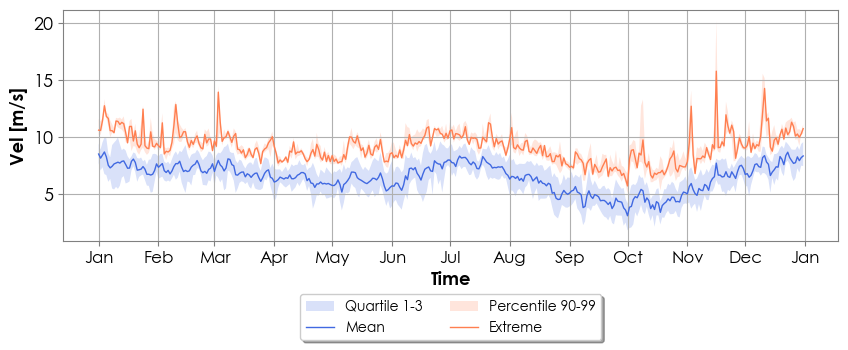

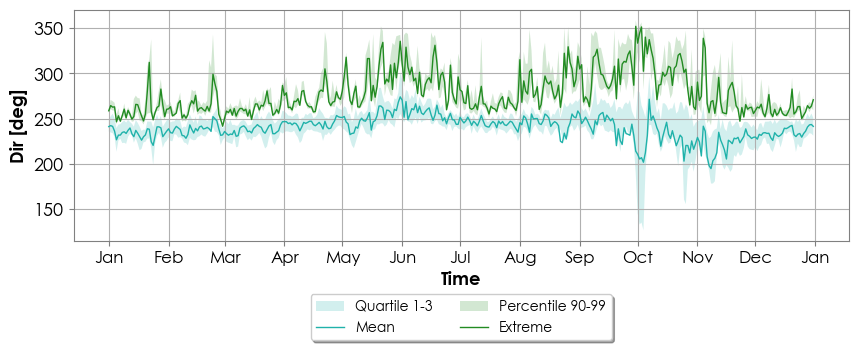

In [71]:
stationaly_figure(variable = 'Vel', data1=df_grouped['Vel_x']['mean'], data2_fill= df_grouped['Vel_x']['q_25'], 
            data3_fill= df_grouped['Vel_x']['q_75'],label_fill = 'Quartile 1-3', 
            color_plot = 'royalblue',label_plot = 'Mean', lw_plot= 1, bottom_legend = -0.2, compare_plot = True,data_compare1= df_grouped['Vel_x']['q_95'], 
                        data_compare_fill2=df_grouped['Vel_x']['q_90'], data_compare_fill3 = df_grouped['Vel_x']['q_99'], 
                        label_fill_compare = 'Percentile 90-99', color_plot_compare = 'coral', label_plot_compare= 'Extreme', lw_plot_compare= 1)

stationaly_figure(variable = 'Direc',data1=df_grouped_dir['Direc_x']['mean'], data2_fill= df_grouped_dir['Direc_x']['q_25'], 
            data3_fill= df_grouped_dir['Direc_x']['q_75'] ,label_fill = 'Quartile 1-3', 
            color_plot = 'lightseagreen',label_plot = 'Mean', lw_plot= 1, bottom_legend = -0.2, compare_plot = True,data_compare1= df_grouped_dir['Direc_x']['q_95'], 
            data_compare_fill2=df_grouped_dir['Direc_x']['q_90'], data_compare_fill3 = df_grouped_dir['Direc_x']['q_99'], 
            label_fill_compare = 'Percentile 90-99', color_plot_compare = 'forestgreen', label_plot_compare= 'Extreme', lw_plot_compare= 1)